# kCHORDS recommendation system

This project focuses on developing a recommendation system that suggests a set of songs based on a user's favorite tracks, provided as YouTube links.  
It's part of the [TAP project](https://github.com/Kespers/kCHORDS), where it will recommend the next song to play based on the one the user just played.

# Table of Contents
1. [What's a recommendation system](#1-whats-a-recommendation-system)  
2. [Why It's Interesting to Build a Recommendation System](#2-why-its-interesting-to-build-a-recommendation-system)  
3. [Data](#3-data)  
4. [Method](#4-method)  
4. [Implementation](#5-implementation)  

# 1 What's a recommendation system

A recommendation system suggests items (e.g. songs, movies, etc.) based on what the user likes or has interacted with.

The main ways to build recommendation systems are:
- **Content-based**: Recommends items based on their features.
- **Collaborative filtering**: Suggests items based on what similar users like.

In this project, we’ll focus on **content-based** recommendations.

# 2 Why It's Interesting to Build a Recommendation System

Building a recommendation system is interesting because it offers the opportunity to personalize user experiences. In the context of music, for example, a recommendation system can enhance discovery by suggesting songs that align with a user's tastes. Rather than passively choosing tracks, users are actively guided to explore new music based on their preferences.

This approach not only improves user satisfaction but also helps artists and platforms by promoting tracks that may otherwise go unnoticed. By utilizing a content-based system, we focus on the individual preferences of users and the unique characteristics of the songs they enjoy.

## 2.1 Content-based approach

A **Content-Based Recommendation System** recommends items to a user by looking at their characteristics and matching them with what the user likes. Instead of depending on what other users do (like in collaborative filtering), it focuses on item features and the user’s own preferences.

We need to follow these steps:

1. **Create User and Item Profiles vectors**

	- **Item profile**: is an item’s representation in the system. It consists of an item’s feature set, which can be internal structured characteristics or descriptive metadata.

	- **User profile** represents user preferences and behavior. It can consist of representations of those items in which a user has previously shown interest.

2. **Compute Similarity Between User and Item**

The similarity score determines how relevant an item is to a user. In general, we define similarity as:

$$
sim(user_{profile}, item_{profile}) = f(user_{profile}, item_{profile})
$$

where $f$ is a similarity function. In this project, we will use **cosine similarity**, defined as:

$$
s(u, i) = \frac{\mathbf{w}_u \cdot \mathbf{x}_i}{\|\mathbf{w}_u\| \|\mathbf{x}_i\|}
$$

- $\mathbf{w}_u$ is the **user profile vector**
- $\mathbf{x}_i$ is the **item profile vector**

3. **Select Top-N Items Based on Score**

Finally, we rank all candidate items by their similarity scores and recommend the top $N$ items with the highest values.

# 3 Data

For similarity search, we need a dataset. Due to recent changes to Spotify's API ([feature extraction deprecated](https://community.spotify.com/t5/Spotify-for-Developers/Web-API-Get-Track-s-Audio-Features-403-error/td-p/6654507)), creating a custom dataset from scratch became impossible. Instead, we used the [**Spotify track dataset**](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset) provided by Huggingface, containing around 40k songs with the following features:

- **track_id**: Unique Spotify ID for the track.
- **artists**: Names of artists, separated by semicolons if multiple.
- **album_name**: Name of the album the track belongs to.
- **track_name**: Title of the track.
- **popularity**: Popularity score from 0-100.
- **duration_ms**: Track length in milliseconds.
- **explicit**: Whether the track contains explicit lyrics (True/False).
- **danceability**: Dance suitability score from 0.0 to 1.0.
- **energy**: Measure of intensity (0.0 = low, 1.0 = high).
- **key**: Musical key (integer values).
- **loudness**: Loudness in decibels (dB).
- **mode**: Major (1) or minor (0) scale.
- **speechiness**: Amount of spoken words (0.0 = none, 1.0 = mostly speech).
- **acousticness**: Confidence in whether the track is acoustic (0.0 to 1.0).
- **instrumentalness**: Likelihood of the track being instrumental (0.0 to 1.0).
- **liveness**: Probability of the track being live (0.0 to 1.0).
- **valence**: Positivity of the track (0.0 = negative, 1.0 = positive).
- **tempo**: Tempo in beats per minute (BPM).
- **time_signature**: Time signature of the track (3/4 to 7/4).
- **track_genre**: Genre of the track.

This dataset required cleaning before performing the similarity search:

1. Removed duplicate entries.
2. Removed irrelevant columns.
3. Retained only the most popular genres, as the raw dataset contained around 125 genres.
4. Applied one-hot encoding to represent genres.
5. Normalized the values to a 0-1 scale.

# 4 Method

The content-based recommendation method focuses on comparing the features of songs liked by the user to those in the dataset, finding the most similar tracks. Features like genre, danceability, and energy are used to compute similarity scores, which help recommend songs with characteristics the user enjoys.

# 5 Implementation
First of all, let's import all the libraries

In [1]:
import json
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.metrics.pairwise import cosine_similarity
import yt_dlp
from essentia.standard import MusicExtractor
import requests
from fuzzywuzzy import process
from requests.auth import HTTPBasicAuth
from collections import Counter
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth
import spotipy
import spacy
import base64
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

[   INFO   ] MusicExtractorSVM: no classifier models were configured by default


### Dataset creation

Import the dataset from [Hugging Face](https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset).

In [2]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

In [3]:
df.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [14]:
# list of all genres
df['track_genre'].unique()

array(['acoustic', 'afrobeat', 'alt-rock', 'alternative', 'ambient',
       'anime', 'black-metal', 'bluegrass', 'blues', 'brazil',
       'breakbeat', 'british', 'cantopop', 'chicago-house', 'children',
       'chill', 'classical', 'club', 'comedy', 'country', 'dance',
       'dancehall', 'death-metal', 'deep-house', 'detroit-techno',
       'disco', 'disney', 'drum-and-bass', 'dub', 'dubstep', 'edm',
       'electro', 'electronic', 'emo', 'folk', 'forro', 'french', 'funk',
       'garage', 'german', 'gospel', 'goth', 'grindcore', 'groove',
       'grunge', 'guitar', 'happy', 'hard-rock', 'hardcore', 'hardstyle',
       'heavy-metal', 'hip-hop', 'honky-tonk', 'house', 'idm', 'indian',
       'indie-pop', 'indie', 'industrial', 'iranian', 'j-dance', 'j-idol',
       'j-pop', 'j-rock', 'jazz', 'k-pop', 'kids', 'latin', 'latino',
       'malay', 'mandopop', 'metal', 'metalcore', 'minimal-techno', 'mpb',
       'new-age', 'opera', 'pagode', 'party', 'piano', 'pop-film', 'pop',
       'pow

Removing duplicates

In [4]:
print("Original dataset rows: ", len(df.index))

df = df.drop_duplicates(subset='track_id', keep='first')
df = df.drop_duplicates(subset='track_name', keep='first')
print("\nDataset rows after removing duplicates of track_id and track_name: ", len(df.index))

Original dataset rows:  114000

Dataset rows after removing duplicates of track_id and track_name:  73609


Removing all the useless columns

In [16]:
df = df.rename(columns={'track_genre': 'genre'})
feat_vec = df.drop(columns=['Unnamed: 0', 'artists', 'album_name', 'track_name', 'duration_ms', 'explicit', 'key', 'mode', 'time_signature'])

Only the most popular genres are kept by filtering the dataset to include those in the `common_genres` list.

In [17]:
common_genres = [
    'acoustic', 'alt-rock', 'alternative', 'ambient', 'blues', 'classical', 'country', 'dance', 
    'disco', 'electro', 'electronic', 'folk', 'funk', 'gospel', 'hip-hop', 'house', 'indie', 'jazz', 
    'latin', 'metal', 'pop', 'rock', 'soul', 'synth-pop', 'techno', 'trance'
]

feat_vec = feat_vec[feat_vec['genre'].isin(common_genres)]

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,acoustic
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,trance
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,trance
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,trance
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,trance


In [18]:
# list of all the current genres
genre_list = feat_vec['genre'].unique().tolist()
print(genre_list)

['acoustic', 'alt-rock', 'alternative', 'ambient', 'blues', 'classical', 'country', 'dance', 'disco', 'electro', 'electronic', 'folk', 'funk', 'gospel', 'hip-hop', 'house', 'indie', 'jazz', 'latin', 'metal', 'pop', 'rock', 'soul', 'synth-pop', 'techno', 'trance']


One-hot encoding to create new columns for each genre, indicating the:
- presence [1]
- absence [0]

of that genre for each item.

In [19]:
for item in genre_list:
    feat_vec['genre_'+item] = feat_vec['genre'].apply(lambda genre: 1 if genre == item else 0)

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,acoustic,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,trance,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
# drop the genre column, with the one-hot encoding we don't need it anymore
feat_vec.drop('genre', axis=1, inplace=True)
feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,73,0.676,0.4610,-6.746,0.1430,0.032200,0.000001,0.3580,0.7150,87.917,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4qPNDBW1i3p13qLCt0Ki3A,55,0.420,0.1660,-17.235,0.0763,0.924000,0.000006,0.1010,0.2670,77.489,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,57,0.438,0.3590,-9.734,0.0557,0.210000,0.000000,0.1170,0.1200,76.332,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6lfxq3CG4xtTiEg7opyCyx,71,0.266,0.0596,-18.515,0.0363,0.905000,0.000071,0.1320,0.1430,181.740,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5vjLSffimiIP26QG5WcN2K,82,0.618,0.4430,-9.681,0.0526,0.469000,0.000000,0.0829,0.1670,119.949,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110995,7sLknEg8aVr0m5ZuCja7b3,28,0.148,0.9930,-7.696,0.0922,0.009700,0.937000,0.0376,0.0928,140.001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110996,6veycwSGozeHSFQ6fbr5dC,28,0.504,0.9850,-7.305,0.0504,0.000810,0.922000,0.1250,0.3830,139.978,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110997,0MLEzWJQcRkc5IMAqucPbV,28,0.474,0.9950,-4.265,0.0979,0.000166,0.369000,0.1500,0.0634,150.002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
110998,0cRNPYxzXLNLQd1g4kKYS6,28,0.416,0.9810,-3.653,0.0943,0.000079,0.928000,0.1870,0.0662,150.054,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Two rows with extreme values for popularity, loudness, and tempo are added to the dataset to normalize the data. Then, those features are scaled to a 0-1 range using MinMax scaling to ensure they are comparable.

In [21]:
min_row = {'popularity': '0', 'loudness': '-60', 'tempo': '0'}
max_row = {'popularity': '100', 'loudness': '0', 'tempo': '250'}

min_row_df = pd.DataFrame([min_row])
max_row_df = pd.DataFrame([max_row])

feat_vec = pd.concat([feat_vec, min_row_df], ignore_index=True)
feat_vec = pd.concat([feat_vec, max_row_df], ignore_index=True)

# scale popularity, loudness, and tempo features to 0-1
scale = ['popularity', 'loudness', 'tempo']
scaler = MinMaxScaler()
feat_vec[scale] = scaler.fit_transform(feat_vec[scale])

feat_vec = feat_vec.iloc[:-2]

feat_vec

,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,5SuOikwiRyPMVoIQDJUgSV,0.73,0.676,0.4610,0.861422,0.1430,0.032200,0.000001,0.3580,0.7150,0.351668,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4qPNDBW1i3p13qLCt0Ki3A,0.55,0.420,0.1660,0.691755,0.0763,0.924000,0.000006,0.1010,0.2670,0.309956,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1iJBSr7s7jYXzM8EGcbK5b,0.57,0.438,0.3590,0.813089,0.0557,0.210000,0.000000,0.1170,0.1200,0.305328,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6lfxq3CG4xtTiEg7opyCyx,0.71,0.266,0.0596,0.671050,0.0363,0.905000,0.000071,0.1320,0.1430,0.726960,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5vjLSffimiIP26QG5WcN2K,0.82,0.618,0.4430,0.813947,0.0526,0.469000,0.000000,0.0829,0.1670,0.479796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12303,7sLknEg8aVr0m5ZuCja7b3,0.28,0.148,0.9930,0.846056,0.0922,0.009700,0.937000,0.0376,0.0928,0.560004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12304,6veycwSGozeHSFQ6fbr5dC,0.28,0.504,0.9850,0.852380,0.0504,0.000810,0.922000,0.1250,0.3830,0.559912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12305,0MLEzWJQcRkc5IMAqucPbV,0.28,0.474,0.9950,0.901554,0.0979,0.000166,0.369000,0.1500,0.0634,0.600008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12306,0cRNPYxzXLNLQd1g4kKYS6,0.28,0.416,0.9810,0.911454,0.0943,0.000079,0.928000,0.1870,0.0662,0.600216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Export the dataset so that it can be used outside of this notebook.

In [22]:
feat_vec.to_csv('DATASET_TO_IMPORT.csv', sep='\t')

In [23]:
feat_vec.columns

Index(['track_id', 'popularity', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'genre_acoustic', 'genre_alt-rock',
       'genre_alternative', 'genre_ambient', 'genre_blues', 'genre_classical',
       'genre_country', 'genre_dance', 'genre_disco', 'genre_electro',
       'genre_electronic', 'genre_folk', 'genre_funk', 'genre_gospel',
       'genre_hip-hop', 'genre_house', 'genre_indie', 'genre_jazz',
       'genre_latin', 'genre_metal', 'genre_pop', 'genre_rock', 'genre_soul',
       'genre_synth-pop', 'genre_techno', 'genre_trance'],
      dtype='object')

An object for similarity calculation is created by dropping the unnecessary columns for these operations.

In [24]:
song_dataset_cosine_sim = feat_vec.drop('track_id', axis=1)

In [25]:
song_dataset_cosine_sim = song_dataset_cosine_sim.loc[:, ~song_dataset_cosine_sim.columns.str.contains('^Unnamed')]
song_dataset_cosine_sim.columns

Index(['popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'genre_acoustic', 'genre_alt-rock', 'genre_alternative',
       'genre_ambient', 'genre_blues', 'genre_classical', 'genre_country',
       'genre_dance', 'genre_disco', 'genre_electro', 'genre_electronic',
       'genre_folk', 'genre_funk', 'genre_gospel', 'genre_hip-hop',
       'genre_house', 'genre_indie', 'genre_jazz', 'genre_latin',
       'genre_metal', 'genre_pop', 'genre_rock', 'genre_soul',
       'genre_synth-pop', 'genre_techno', 'genre_trance'],
      dtype='object')

### Feature extraction  
In this section, the input song is processed to extract features matching the dataset, following these steps:
1. **Download the Audio**  
   - Extracts the MP3 from the youtube link.  

2. **Extract Song Features**  
   Using **MusicExtractor** library, the system retrieves key musical attributes, including:  
   - Danceability  
   - Energy  
   - Loudness  
   - Speechiness  
   - Acousticness  
   - Instrumentalness  
   - Liveness  
   - Valence  
   - Tempo  

3. **Calculate Popularity**  
   The system determines a song’s popularity by analyzing YouTube metadata, including:  
   - Likes  
   - Comments  
   - Views  

4. **Extract Genre**  
   Since the Spotify API only provides genres related to artists and not specific to individual songs, the system determines the genre using two possible approaches:
   1. Since the TAP project pipeline includes a website that provides song-related chords, it will use Web scraping to extract the artist's name and fetch the genre from Spotify.
	2. If the first method fails, the system uses a basic **SpaCy NLP** Named Entity Recognition (NER) model to extract artist names from YouTube metadata (such as the title, description, and tags). The most likely artist is then queried in the Spotify API to determine their most common genre.

For simplicity, in this notebook, we will extract the genre using only SpaCy. In the [TAP project](https://github.com/Kespers/kCHORDS/tree/main/chords-scraper), there is a Flask server that allows the scraping

#### Download MP3 audio  
The audio is downloaded and converted into the MP3 format using the libmp3lame codec for optimal feature extraction.

In [ ]:
def convert_to_optimal_codec(song_path, output_path):
    print("\t convertin codec")
    os.system(f"ffmpeg -i {song_path} -acodec libmp3lame {output_path} -y")

def download_mp3(song):
	id = song['Yt_Id']
	link = song['Yt_Link']      

	raw_path = f'./songs/{id}/raw_song.mp3'
	output_path = f'./songs/{id}/song.mp3'
	ydl_opts = {
		'format': 'bestaudio/best',
		'extractaudio': True,
		'outtmpl': raw_path,
		'noplaylist': True
	}

	try:
		with yt_dlp.YoutubeDL(ydl_opts) as ydl:
			info_dict = ydl.extract_info(link, download=True)
			song_name = info_dict['title']

			convert_to_optimal_codec(raw_path, output_path)

			return output_path
	except Exception as e:
		raise e

def download_songs_mp3(songs):
    with ThreadPoolExecutor() as executor:
        list(executor.map(download_mp3, songs))

Extract info from youtube link

In [68]:
# getting yt video data by id
def get_video_data(query: str = None, video_id: str = None):
    YT_KEY = os.getenv('GOOGLE_TOKEN')

    if not YT_KEY:
        raise ValueError("Google API key is missing. Please set 'GOOGLE_TOKEN' in the environment variables.")

    base_url = 'https://www.googleapis.com/youtube/v3'

    if video_id:
        url = f'{base_url}/videos'
        params = {
            'key': YT_KEY,
            'id': video_id,
            'part': 'snippet,statistics,contentDetails',
        }
    elif query:
        url = f'{base_url}/search'
        params = {
            'key': YT_KEY,
            'q': query,
            'part': 'snippet',
            'type': 'video',
            'maxResults': 1
        }
    else:
        raise ValueError("Devi fornire un video_id o una query!")

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        if video_id:
            if 'items' in data and len(data['items']) > 0:
                video_info = data['items'][0]
                return {
                    'video_id': video_id,
                    'title': video_info['snippet']['title'],
                    'description': video_info['snippet']['description'],
                    'tags': video_info['snippet'].get('tags', []),
                    'view_count': video_info['statistics']['viewCount'],
                    'like_count': video_info['statistics'].get('likeCount', 'N/A'),
                    'comment_count': video_info['statistics'].get('commentCount', 'N/A'),
                    'duration': video_info['contentDetails']['duration']
                }
        elif query:
            if 'items' in data and len(data['items']) > 0:
                first_video = data['items'][0]
                video_id = first_video['id']['videoId']
                return {
                    'video_id': video_id,
                    'title': first_video['snippet']['title'],
                    'description': first_video['snippet']['description'],
                    'channel_title': first_video['snippet']['channelTitle'],
                    'video_link': f'https://www.youtube.com/watch?v={video_id}'
                }
    else:
        print(f"Errore durante la richiesta: {response.status_code}")
    return None


def get_video_by_id(video_id):
    return get_video_data(video_id=video_id)


def get_video_by_name(query):
    return get_video_data(query=query)

#### Extracting song feature

In [19]:
def get_artist_genre(artist_name, dataset_genres, spotify):
    if not artist_name or artist_name.isspace():
        return []
    
    result = spotify.search(q=artist_name, type='artist', limit=1)
    genres = []
    if result['artists']['items']:
        genres = result['artists']['items'][0].get('genres', [])
    
    return genres

def get_song_info(song_id, spotify):
    try:
        track_info = spotify.track(song_id)
        
        song_data = {
            "name": track_info["name"],
            "artists": [artist["name"] for artist in track_info["artists"]],
            "album": track_info["album"]["name"],
            "link": track_info["external_urls"]["spotify"],
        }
        return song_data

    except Exception as e:
        print(f"Errore durante il recupero delle informazioni della canzone: {e}")
        return None

def get_client():
    CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
    CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

    # Autenticazione con Spotify
    client_credentials_manager = SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET
    )

    return spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Extract the genre and map it to the set of genres present in the dataset, as the extracted genre might not always be included in the available genres.

In [20]:
def extract_person_from_video_data(video_data):
    """
    get possible person entities from the video
    """
    nlp = spacy.load('en_core_web_sm')
    text_to_search = video_data['title'] + " " + video_data['description'] + " " + " ".join(video_data['tags'])
    doc = nlp(text_to_search)

    person_entities = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

    return person_entities if person_entities else None

def dataset_mapping(genres):
    most_similar_genre = None
    highest_similarity = 0

    for genre in genres:
        best_match = process.extractOne(genre, genre_list)
        if best_match:
            similarity_score = best_match[1]
            if similarity_score > highest_similarity:
                highest_similarity = similarity_score
                most_similar_genre = best_match[0]

    return most_similar_genre

def get_genre_df(artists, video_data):
    """
    get same dataset as the created one by huggingface
    """
    def get_from_artist(artists):
        if not artists:
            return None
        
        genres = []
        for artist in artists:
            raw_genre = get_artist_genre(artist, genre_list, spotify=get_client())
            if raw_genre:
                artist_genre = dataset_mapping(raw_genre)
                
                if artist_genre:
                    genres.append(artist_genre)
            
        genre_counts = Counter(genres)
        return genre_counts.most_common(1)[0][0] if genre_counts else None

	# extract genre
    genre = get_from_artist(artists)
    if not genre:
        genre = get_from_artist(extract_person_from_video_data(video_data))

    genre_df = pd.DataFrame() 

    print(f"\tTitle: {video_data['title']} - Genre: ", genre)

    # one-hot encoding
    genre_encoding = {f'genre_{g}': [1 if g == genre else 0] for g in genre_list}
    genre_df = pd.DataFrame(genre_encoding)

    return genre_df

Popularity is calculated as a weighted average based on the number of:  
- likes  
- views  
- comments

In [21]:
def get_popularity_score(video_info):
    view_count = int(video_info['view_count'])
    like_count = int(video_info['like_count'])
    comment_count = int(video_info['comment_count'])

    max_view_count = 100000  
    max_like_count = 1000    
    max_comment_count = 100 

    
    normalized_view_count = view_count / max_view_count
    normalized_like_count = like_count / max_like_count
    normalized_comment_count = comment_count / max_comment_count

    
    normalized_view_count = min(normalized_view_count, 1)
    normalized_like_count = min(normalized_like_count, 1)
    normalized_comment_count = min(normalized_comment_count, 1)

    
    weight_view_count = 0.2
    weight_like_count = 0.3
    weight_comment_count = 0.25

    
    popularity_score = (
        weight_view_count * normalized_view_count +
        weight_like_count * normalized_like_count +
        weight_comment_count * normalized_comment_count
    )

    
    return round(popularity_score, 2)

def get_song_stats(song_path, video_data):
	music_extractor = MusicExtractor(
		lowlevelStats=['mean', 'stdev'],
		rhythmStats=['mean', 'stdev'],
		tonalStats=['mean', 'stdev']
	)
	
	features, _ = music_extractor(song_path)
	
	stats = {
		"danceability": features["rhythm.danceability"], 
		"energy": features["lowlevel.spectral_energy.mean"],
		"loudness": features["lowlevel.average_loudness"], 
		"speechiness": features["lowlevel.spectral_entropy.mean"],
		"acousticness": features["lowlevel.melbands_flatness_db.mean"],
		"instrumentalness": features["lowlevel.pitch_salience.mean"],
		"liveness": features["lowlevel.spectral_flux.mean"],
		"valence": features["tonal.chords_strength.mean"],
		"tempo": features["rhythm.bpm"],
		"popularity": get_popularity_score(video_data)
	}
	
	song_stats_df = pd.DataFrame([stats])
	
	min_row = {'popularity': '0', 'loudness': '-60', 'tempo': '0'}
	max_row = {'popularity': '100', 'loudness': '0', 'tempo': '250'}

	min_row_df = pd.DataFrame([min_row])
	max_row_df = pd.DataFrame([max_row])

	song_stats_df = pd.concat([song_stats_df, min_row_df], ignore_index=True)
	song_stats_df = pd.concat([song_stats_df, max_row_df], ignore_index=True)

	scale = ['popularity', 'loudness', 'tempo']
	scaler = MinMaxScaler()
	song_stats_df[scale] = scaler.fit_transform(song_stats_df[scale])

	song_stats_df = song_stats_df.iloc[:-2]

	return song_stats_df

## User Profile Creation  
Given a set of songs, we will process them using the functions defined earlier. A multithreading approach will be used since the operations are computationally expensive, and processing them with a single thread would take too long.

In [23]:
def process_song(song):
	video_id = song['Yt_Id']
	song_path = song['Song_Path']
	artists = song['Artists']

	print(f"Processing: {song_path}")

	video_data = get_video_by_id(video_id)
	genre_df = get_genre_df(artists, video_data)
	song_stat_df = get_song_stats(song_path, video_data)

	song_data_df = pd.concat([song_stat_df, genre_df], axis=1)

	# Add Artists and Video ID columns
	song_data_df['Artists'] = ', '.join(artists)
	song_data_df['Video_ID'] = video_id

	if not os.path.exists('./df'):
		os.makedirs('./df')

	song_data_df.to_csv(f'./df/{video_id}_df.csv', index=False)


def extract_songs_data(songs):
    with ThreadPoolExecutor() as executor:
        list(executor.map(process_song, songs))


Define the recommendation function by calculating a similarity score and returning the top `recommendation_count` items, sorted based on the value of this score.

In [24]:
def get_recommendation(dataset, song_df, genres, recommendation_count):
		similarity_scores = cosine_similarity(dataset, song_df)

		dataset['similarity_score'] = similarity_scores

		return dataset \
			.sort_values(by='similarity_score', ascending=False) \
			.head(recommendation_count) \
			['track_id']

## Demo  
The songs within the pipeline will arrive in the following format:

In [29]:
songs = [
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=unRjK82bDLw',
        'Yt_Id': 'unRjK82bDLw',
        'Artists': [
            'Marco Mengoni'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=E3sP6AXKuYg',
        'Yt_Id': 'E3sP6AXKuYg',
        'Artists': [
            'David Gilmour'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=nVa0GPeuVk4',
        'Yt_Id': 'nVa0GPeuVk4',
        'Artists': [
            'Olly', 
            'Angelina Mango', 
            'JVLI'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=u-cx3TN7Sho',
        'Yt_Id': 'u-cx3TN7Sho',
        'Artists': [
            'Rose Villain',
            'Guè'
        ]
    },
    {
        'Yt_Link': 'https://www.youtube.com/watch?v=v2AC41dglnM',
        'Yt_Id': 'v2AC41dglnM',
        'Artists': [
            'AC/DC'
        ]
    }
]

In [ ]:
download_songs_mp3(songs)

Associating the MP3 file path with each song to for audio feature extraction.

In [30]:
for song in songs:
    song['Song_Path'] = f'./songs/{song["Yt_Id"]}/song.mp3'
    print(song['Song_Path'])

./songs/unRjK82bDLw/song.mp3
./songs/E3sP6AXKuYg/song.mp3
./songs/nVa0GPeuVk4/song.mp3
./songs/u-cx3TN7Sho/song.mp3
./songs/v2AC41dglnM/song.mp3


In [ ]:
extract_songs_data(songs)

Since a multithreading approach was used, it was necessary to ensure atomic saving for each operation. The previous method will generate a series of CSV files in the format `./df/{song['Yt_Id']}_df.csv`.

These files will need to be re-aggregated.

In [37]:
song_df = pd.concat(
    [pd.read_csv(f"./df/{song['Yt_Id']}_df.csv") for song in songs],
    ignore_index=True,
)

In [38]:
song_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,1.029173,0.023112,1.0,7.545177,0.202679,0.542803,0.066513,0.544834,0.503434,0.0075,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.183636,0.031970,1.0,7.142763,0.268807,0.521351,0.076659,0.525631,0.493890,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.168210,0.034790,1.0,7.408294,0.230346,0.538261,0.077632,0.527097,0.387358,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.193732,0.039334,1.0,7.236877,0.259844,0.470456,0.096940,0.514170,0.560008,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1.194661,0.020659,1.0,7.903380,0.149156,0.585290,0.074827,0.573681,0.535406,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


The column averages are calculated to summarize the data and create an object that holds the central value for each feature.

This object is then used to compare the input song with the dataset for similarity calculations.

In [70]:
column_averages = song_df.mean()

averages_cosine_sim = pd.DataFrame([column_averages], index=['Average'])

averages_cosine_sim = averages_cosine_sim.loc[:, ~averages_cosine_sim.columns.str.contains('^Unnamed')]

Calculation of a similarity score for each song in the dataset to rank them based on this score and generate recommendations.

In [72]:
similarity_scores = cosine_similarity(song_dataset_cosine_sim, averages_cosine_sim)
 
feat_vec['similarity_score'] = similarity_scores
 
top_similarities = feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

top_similarities

,Unnamed: 0.1,track_id,popularity,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance,similarity_score
8207,40421.0,0nFYYqz5suiZ7lVh2FK4wL,0.42,0.164,0.749,0.918992,0.0381,0.4250,0.00965,0.121,0.0721,0.318896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.642670
10562,91524.0,0puCOCSanni13tgXPVq192,0.01,0.365,0.517,0.863218,0.0243,0.0622,0.00000,0.265,0.0777,0.375448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.642518
3885,16573.0,02bERDuJxtWLvIApFJn5Ba,0.30,0.258,0.637,0.892043,0.0323,0.2740,0.00000,0.111,0.2020,0.356076,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640395
577,637.0,18k8IlS52uxRWObykDUZFG,0.60,0.236,0.578,0.881949,0.0404,0.3270,0.00015,0.206,0.2270,0.301468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640062
2962,8397.0,2oPv5XfZvGsPD8m7oBl5aJ,0.00,0.132,0.420,0.845004,0.0368,0.2090,0.00293,0.110,0.1850,0.183428,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.638424


Formatting the recommendations to create an object containing the song links and key information.

In [73]:
recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

recommended_songs

[{'name': 'Cordeiro e Leão (Ao Vivo)',
  'artists': ['Central 3'],
  'album': 'Cordeiro e Leão (Ao Vivo)',
  'link': 'https://open.spotify.com/track/0nFYYqz5suiZ7lVh2FK4wL'},
 {'name': 'Ode To My Family',
  'artists': ['The Cranberries'],
  'album': 'Los Clásicos del Pop 90s',
  'link': 'https://open.spotify.com/track/0puCOCSanni13tgXPVq192'},
 {'name': 'Bolava Vitthal Pahava Vitthal',
  'artists': ['Jayateerth Mevundi'],
  'album': 'Jayateerth Mevundi',
  'link': 'https://open.spotify.com/track/02bERDuJxtWLvIApFJn5Ba'},
 {'name': 'The Joke',
  'artists': ['Brandi Carlile'],
  'album': 'By the Way, I Forgive You',
  'link': 'https://open.spotify.com/track/18k8IlS52uxRWObykDUZFG'},
 {'name': 'The Night',
  'artists': ['The Moody Blues'],
  'album': 'Fiesta temática 60s',
  'link': 'https://open.spotify.com/track/2oPv5XfZvGsPD8m7oBl5aJ'}]

## Evaluation  
The performance of the recommendation system is tested through the following steps:

1. Collect the top 5 favorite songs of 10 users.
2. Generate recommendations based on these songs using two methods:
   - Basic similarity-search
   - Similarity-search, keeping only the songs with the user's most preferred genre among the preferred ones.
3. Create a spotify playlist for each user with the recommended songs.
4. Conduct a survey to assess the quality of the recommendations.
5. Calculate the performance metrics.

The favorite songs are saved in files of the format `./evaluation/fav_songs/{USER_ID}.json`.

In [26]:
users_fav_songs = []

for i in range(1, 11):
	file_path = f'./evaluation/fav_songs/{i}.json'
	if os.path.exists(file_path):
		with open(file_path, 'r') as file:
			user_songs = json.load(file)
			for song in user_songs:
				song['Song_Path'] = f'./songs/{song["Yt_Id"]}/song.mp3'
				song.pop('id', None)
			users_fav_songs.append({'Songs': user_songs, 'Id': i})

users_fav_songs[0]


{'Songs': [{'Yt_Link': 'https://www.youtube.com/watch?v=7YvAYIJSSZY',
   'Yt_Id': '7YvAYIJSSZY',
   'Artists': ['Rockwell'],
   'Song_Path': './songs/7YvAYIJSSZY/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=3GwjfUFyY6M',
   'Yt_Id': '3GwjfUFyY6M',
   'Artists': ['Kool & The Gang'],
   'Song_Path': './songs/3GwjfUFyY6M/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=htgr3pvBr-I',
   'Yt_Id': 'htgr3pvBr-I',
   'Artists': ['Toto'],
   'Song_Path': './songs/htgr3pvBr-I/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=MA3OVz-dpzI',
   'Yt_Id': 'MA3OVz-dpzI',
   'Artists': ['Squallor'],
   'Song_Path': './songs/MA3OVz-dpzI/song.mp3'},
  {'Yt_Link': 'https://www.youtube.com/watch?v=o6aJJ6Q5zhg',
   'Yt_Id': 'o6aJJ6Q5zhg',
   'Artists': ['TOMMY CASH'],
   'Song_Path': './songs/o6aJJ6Q5zhg/song.mp3'}],
 'Id': 1}

Process the songs

In [ ]:
for user_songs in users_fav_songs:
	download_songs_mp3(user_songs['Songs'])

In [ ]:
for user_songs in users_fav_songs:
	extract_songs_data(user_songs['Songs'])

In [67]:
users_df = []

for user_songs in users_fav_songs:
	user_song_df = pd.concat(
		[pd.read_csv(f"./df/{song['Yt_Id']}_df.csv") for song in user_songs['Songs']],
		ignore_index=True,
	)
	users_df.append(user_song_df)

users_df[0]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance,Artists,Video_ID
0,1.555607,0.018258,1.0,7.731660,0.164686,0.507180,0.074870,0.530233,0.490187,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Rockwell,7YvAYIJSSZY
1,1.947881,0.018525,1.0,7.580819,0.177774,0.567735,0.075016,0.527196,0.481487,0.0075,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kool & The Gang,3GwjfUFyY6M
2,1.206299,0.016247,1.0,7.837966,0.146385,0.588250,0.072917,0.489380,0.380943,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,toto,htgr3pvBr-I
3,1.131466,0.019871,1.0,7.586553,0.171737,0.551796,0.072023,0.512603,0.472217,0.0075,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Squallor,MA3OVz-dpzI
4,1.107264,0.047339,1.0,7.475175,0.232909,0.468376,0.105459,0.533753,0.478913,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,TOMMY CASH,o6aJJ6Q5zhg


In [68]:
similarity_df = [df.drop(columns=['Artists', 'Video_ID']) for df in users_df]
similarity_df[1]

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity,genre_acoustic,genre_alt-rock,genre_alternative,genre_ambient,genre_blues,genre_classical,genre_country,genre_dance,genre_disco,genre_electro,genre_electronic,genre_folk,genre_funk,genre_gospel,genre_hip-hop,genre_house,genre_indie,genre_jazz,genre_latin,genre_metal,genre_pop,genre_rock,genre_soul,genre_synth-pop,genre_techno,genre_trance
0,1.288900,0.047113,1.0,7.725337,0.203537,0.526613,0.108169,0.621465,0.608626,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1.197234,0.034435,1.0,7.717242,0.187582,0.586884,0.098828,0.538202,0.415386,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1.162408,0.032681,1.0,7.822676,0.145040,0.579206,0.093396,0.536339,0.615801,0.0064,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1.252538,0.035167,1.0,7.348411,0.274081,0.524823,0.084495,0.557368,0.415985,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0.999874,0.025293,1.0,7.429679,0.216206,0.564732,0.071162,0.534728,0.624762,0.0075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [100]:
def get_similarity_scores(song_df):
	column_averages = song_df.mean()

	averages_cosine_sim = pd.DataFrame([column_averages], index=['Average'])

	averages_cosine_sim = averages_cosine_sim.loc[:, ~averages_cosine_sim.columns.str.contains('^Unnamed')]

	return cosine_similarity(song_dataset_cosine_sim, averages_cosine_sim)

Generate the two types of recommendations.

In [109]:
def content_based_recommendation(song_df, idx):
	similarity_scores = get_similarity_scores(song_df)
	
	_feat_vec = feat_vec
	_feat_vec['similarity_score'] = similarity_scores

	top_similarities = _feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

	top_similarities.to_csv(f'./evaluation/recommends/{idx}_normal.csv', index=False)

	recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

	return recommended_songs

In [27]:
def content_based_recommendation_fav_genre(song_df, idx):
	similarity_scores = get_similarity_scores(song_df)
	
	fav_genre = song_df.filter(like='genre_').sum().idxmax().replace('genre_', '')

	_feat_vec = feat_vec[feat_vec['genre_' + fav_genre] == 1].copy()
	_feat_vec['similarity_score'] = similarity_scores[:len(_feat_vec)]

	top_similarities = _feat_vec.sort_values(by='similarity_score', ascending=False).head(5)

	top_similarities.to_csv(f'./evaluation/recommends/{idx}_fav_genre.csv', index=False)

	recommended_songs = [get_song_info(track_id, get_client()) for track_id in top_similarities['track_id']]

	return recommended_songs

The recommended songs are saved into individual JSON files of the format `/evaluation/recommends/{USER_ID}.json.`

In [ ]:
recommends = []

for idx, df in enumerate(similarity_df, start=1):
	recommends.append({
		'id': idx,
		'normal': content_based_recommendation(df, idx),
		'fav_song': content_based_recommendation_fav_genre(df, idx)
	})

recommends

In [112]:
for recommend in recommends:
	recommend_copy = recommend.copy()
	recommend_copy.pop('id', None)
	file_path = f"./evaluation/recommends/{recommend['id']}.json"
	os.makedirs(os.path.dirname(file_path), exist_ok=True)
	with open(file_path, 'w') as file:
		json.dump(recommend_copy, file, indent=4)

Each user now has a playlist with these songs.

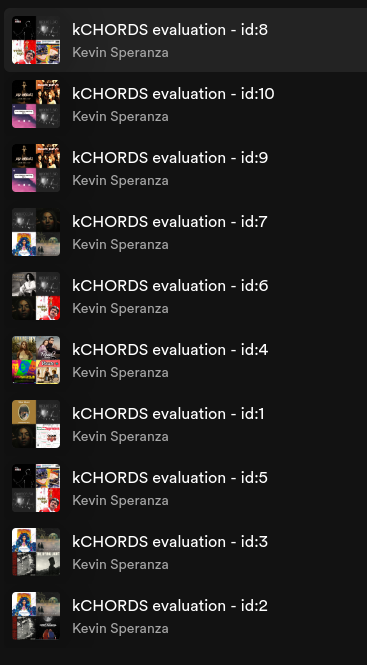

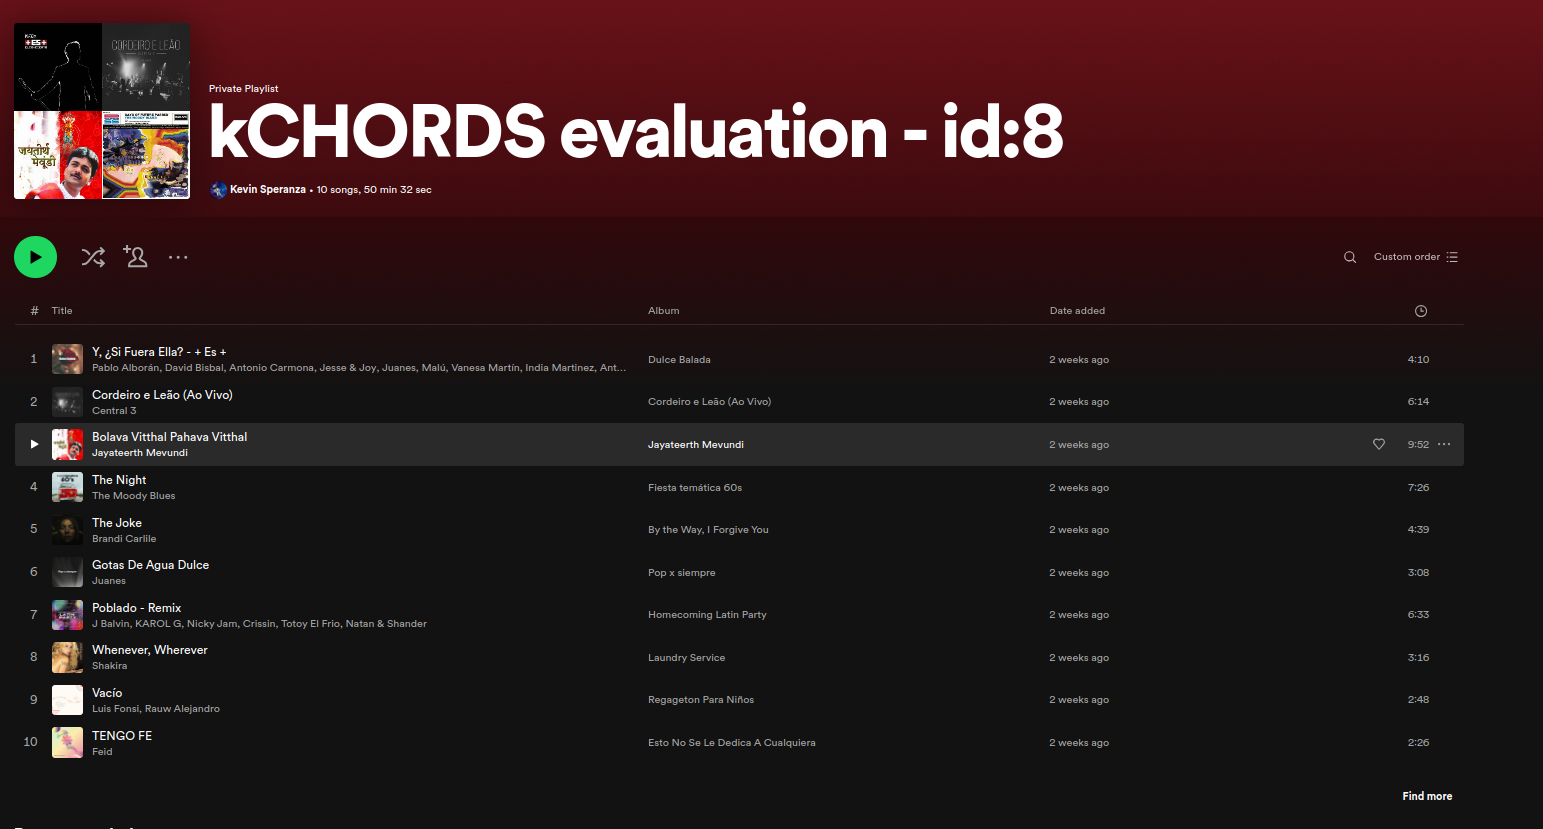

### Results
A survey was administered asking users to rate the 10 songs on a scale from 1 to 5, with an additional question at the end asking how closely the recommendations matched their musical tastes.

The responses have been saved in the `./evaluation/results/results.csv` file.

In [2]:
results = pd.read_csv('./evaluation/results/results.csv')
results

,id,1_song_rating,2_song_rating,3_song_rating,4_song_rating,5_song_rating,6_song_rating,7_song_rating,8_song_rating,9_song_rating,10_song_rating,overall
0,8,5,3,1,3,4,3,4,5,4,4,Abbastanza
1,1,1,2,2,1,1,1,1,1,1,1,Per niente
2,3,2,3,4,3,2,2,2,2,2,2,Per niente
3,2,1,3,4,1,1,4,1,1,1,1,Abbastanza
4,5,2,2,1,1,1,2,1,2,2,1,Per niente
5,4,2,1,3,1,1,1,4,1,3,1,Per niente
6,6,1,1,3,1,2,1,1,1,3,1,Per niente
7,7,1,1,1,4,1,2,1,1,1,1,Per niente
8,9,2,4,2,1,1,1,1,1,1,2,Per niente
9,10,2,4,3,1,1,3,2,2,4,3,Abbastanza


It's clear that the general sentiment isn't very positive, with a strong predominance of "Per niente" in the overall responses, meaning the experience was considered very bad.

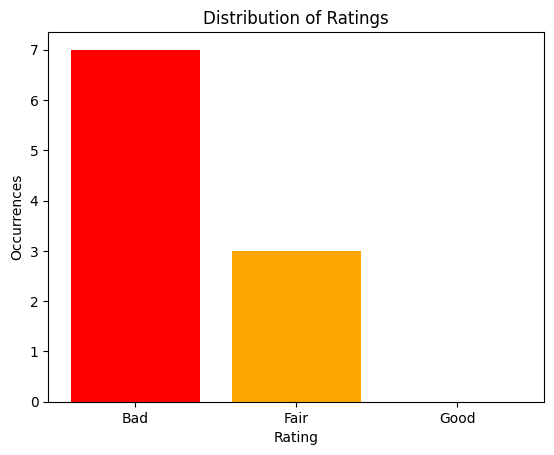

In [ ]:
counts = results['overall'].value_counts()

categories = ['Per niente', 'Abbastanza', 'Molto']
labels = ['Bad', 'Fair', 'Good']
values = [counts.get(cat, 0) for cat in categories]

plt.bar(labels, values, color=['red', 'orange', 'green'])

plt.xlabel('Rating')
plt.ylabel('Occurrences')
plt.title('Distribution of Ratings')
plt.show()

Now let's visualize the ratings.

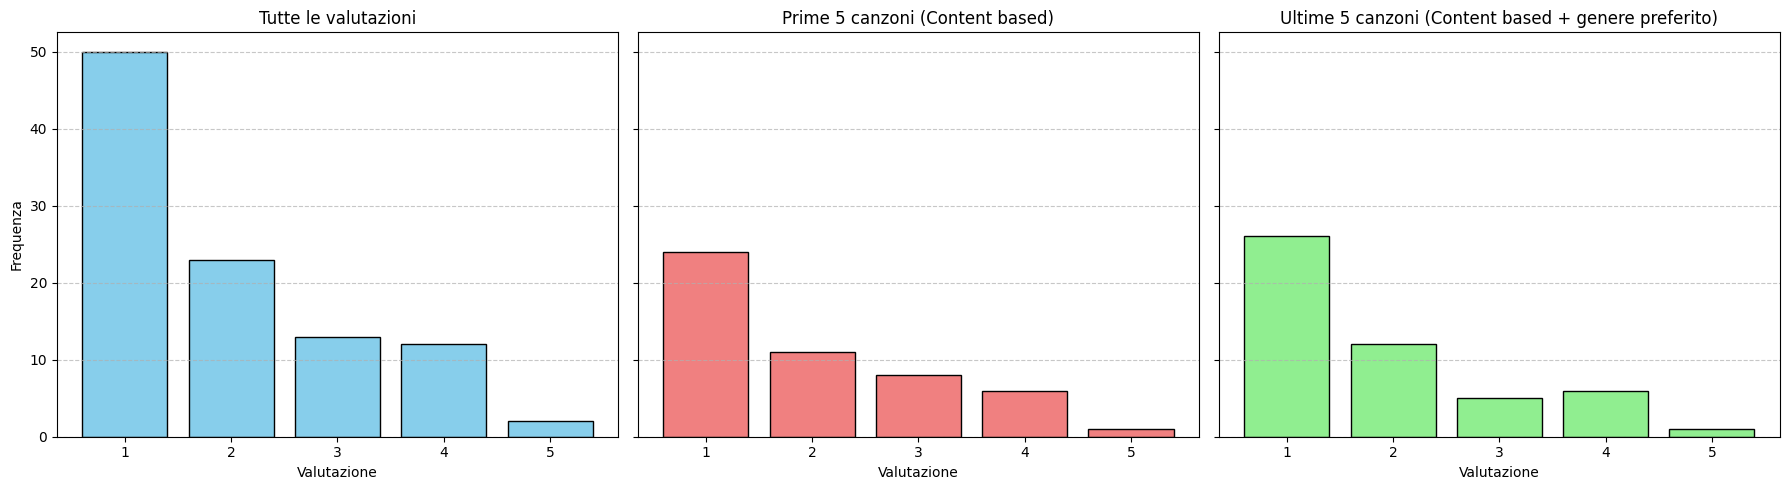

In [5]:
ratings_columns = results.columns[1:-1]
ratings_group1 = ratings_columns[:5]  
ratings_group2 = ratings_columns[5:]  

value_counts_all = pd.Series(results[ratings_columns].values.flatten()).value_counts().sort_index()
value_counts_group1 = pd.Series(results[ratings_group1].values.flatten()).value_counts().sort_index()
value_counts_group2 = pd.Series(results[ratings_group2].values.flatten()).value_counts().sort_index()

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].bar(value_counts_all.index, value_counts_all.values, color='skyblue', edgecolor='black')
axes[0].set_title("Tutte le valutazioni")
axes[0].set_xlabel("Valutazione")
axes[0].set_ylabel("Frequenza")
axes[0].set_xticks(range(1, 6))
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

axes[1].bar(value_counts_group1.index, value_counts_group1.values, color='lightcoral', edgecolor='black')
axes[1].set_title("Prime 5 canzoni (Content based)")
axes[1].set_xlabel("Valutazione")
axes[1].set_xticks(range(1, 6))
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

axes[2].bar(value_counts_group2.index, value_counts_group2.values, color='lightgreen', edgecolor='black')
axes[2].set_title("Ultime 5 canzoni (Content based + genere preferito)")
axes[2].set_xlabel("Valutazione")
axes[2].set_xticks(range(1, 6))
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

As seen in the graphs, the performance is poor, with the most frequent rating being 1.

Additionally, there is not much difference between the two recommendation methods, indicating that both approaches are producing similar, disappointing results. This highlights the need for significant improvements to better align the recommendations with user preferences.

### Metrics
Metrics are used to evaluate the performance of the recommendation system. They help to assess how well the system predicts user preferences and how relevant the recommendations are.

##### Accuracy

Accuracy represents the percentage of ratings that are greater than or equal to 3 out of all ratings. It is calculated as:

$$
\text{Accuracy} = \frac{\text{Number of ratings} \geq 3}{\text{Total number of ratings}}
$$

In [3]:
positive_rate = np.mean((results.iloc[:, 1:11] >= 3).sum().sum())
print(f"Accuracy: {int(positive_rate)}%")

Accuracy: 27%


Only 27% of the ratings are considered "good" (3 or above).

This shows that the system is mostly recommending things that users don't find that great.

### Order-Aware Metrics
Order-aware metrics check how good a ranked list is by looking at where items are placed. They give more importance to relevant items that show up higher in the list and penalize those that are ranked lower.

These metrics help see how well a system ranks items based on relevance, making sure the most relevant results appear first.

Let's start with the preprocessing to calculate the metrics.

In [8]:
# drop the useless columns
metrics_data = results.drop(columns=['id', 'overall'])
metrics_data

,1_song_rating,2_song_rating,3_song_rating,4_song_rating,5_song_rating,6_song_rating,7_song_rating,8_song_rating,9_song_rating,10_song_rating
0,5,3,1,3,4,3,4,5,4,4
1,1,2,2,1,1,1,1,1,1,1
2,2,3,4,3,2,2,2,2,2,2
3,1,3,4,1,1,4,1,1,1,1
4,2,2,1,1,1,2,1,2,2,1
5,2,1,3,1,1,1,4,1,3,1
6,1,1,3,1,2,1,1,1,3,1
7,1,1,1,4,1,2,1,1,1,1
8,2,4,2,1,1,1,1,1,1,2
9,2,4,3,1,1,3,2,2,4,3


The success is determined by a rating of 3 or higher.

In [9]:
def convert_to_binary(success):
    return [1 if x >= 3 else 0 for x in success]


metrics_data_list = metrics_data.values.tolist()


binary_metrics_data = np.array([convert_to_binary(row) for row in metrics_data_list])
binary_metrics_data

array([[1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 0, 0, 1, 1]])

#### Normalized Discounted Cumulative Gain at k (NDCG@k)
It evaluates how well the system ranks relevant items by looking at both their importance and placement in the list.

$NDCG$ normalizes $DCG$ by comparing it with the $\text{Ideal DCG} (IDCG)$:

$$ NDCG@k = \frac{DCG@k}{IDCG@k} $$

Where:
- $DCG@k=\sum_{i=1}^{k} \frac{rel_i}{\log_2(i+1)}$: Discounted Cumulative Gain 

- $IDCG@k$: the Ideal Discounted Cumulative Gain

NDCG takes into account the positions of relevant results, penalizing those in lower positions.

In [ ]:
from sklearn.metrics import ndcg_score
# higher relevance for the first positions
true_relevance = np.arange(5, 0, -1)
ndcg_scores_content_based = [0.0 if np.all(row == 0) else ndcg_score([true_relevance], [row[:5]], k=None) for row in binary_metrics_data]
ndcg_scores_fav_genre = [0.0 if np.all(row == 0) else ndcg_score([true_relevance], [row[5:]], k=None) for row in binary_metrics_data]

Basic similarity search scores

In [16]:
df_ndcg_group1 = pd.DataFrame(binary_metrics_data[:, :5], columns=[f'Song_{i+1}' for i in range(5)])
df_ndcg_group1['NDCG Scores'] = ndcg_scores_content_based
df_ndcg_group1

,Song_1,Song_2,Song_3,Song_4,Song_5,NDCG Scores
0,1,1,0,1,1,0.861122
1,0,0,0,0,0,0.000000
2,0,1,1,1,0,0.861122
3,0,1,1,0,0,0.897754
4,0,0,0,0,0,0.000000
5,0,0,1,0,0,0.861122
6,0,0,1,0,0,0.861122
7,0,0,0,1,0,0.811191
8,0,1,0,0,0,0.911052
9,0,1,1,0,0,0.897754


Similarity search + favourite genre scores

In [17]:
df_ndcg_group2 = pd.DataFrame(binary_metrics_data[:, 5:], columns=[f'Song_{i+6}' for i in range(5)])
df_ndcg_group2['NDCG Scores'] = ndcg_scores_fav_genre
df_ndcg_group2

,Song_6,Song_7,Song_8,Song_9,Song_10,NDCG Scores
0,1,1,1,1,1,0.861122
1,0,0,0,0,0,0.000000
2,0,0,0,0,0,0.861122
3,1,0,0,0,0,0.960983
4,0,0,0,0,0,0.000000
5,0,1,0,1,0,0.861122
6,0,0,0,1,0,0.811191
7,0,0,0,0,0,0.861122
8,0,0,0,0,0,0.861122
9,1,0,0,1,1,0.831765


In [18]:
mean_ndcg_content_based = np.mean(ndcg_scores_content_based)
mean_ndcg_fav_genre = np.mean(ndcg_scores_fav_genre)

ndcg_df = pd.DataFrame({
	'Mean NDCG': [
		f"{int(mean_ndcg_content_based * 100)} %",
		f"{int(mean_ndcg_fav_genre * 100)} %"
	]
}, index=['Similarity search', 'Similarity search + Fav genre filter'])

ndcg_df

,Mean NDCG
Similarity search,69 %
Similarity search + Fav genre filter,69 %


There's no significant difference in performance between the two approaches.

### Frequency Analysis

During the creation of recommendations, it was noticed that the system tends to repeatedly recommend the same songs, which may indicate a bias in the recommendations.

Let’s verify how many songs have been recommended more than 2 times. First, we will read the data from the various JSON files where the recommendations have been saved.

In [30]:
folder_path = "evaluation/recommends"
recommends = []

for idx in range(1, 11):
    file_path = os.path.join(folder_path, f"{idx}.json")
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

        for category in data.values():
            for song in category:
                if song and song["name"] and song["link"]:  
                    recommends.append({"name": song["name"], "link": song["link"]})

print(recommends[0])

{'name': 'Words', 'link': 'https://open.spotify.com/track/07PIhdmyYIw8dMeDMsx9FU'}


Plot the duplicates

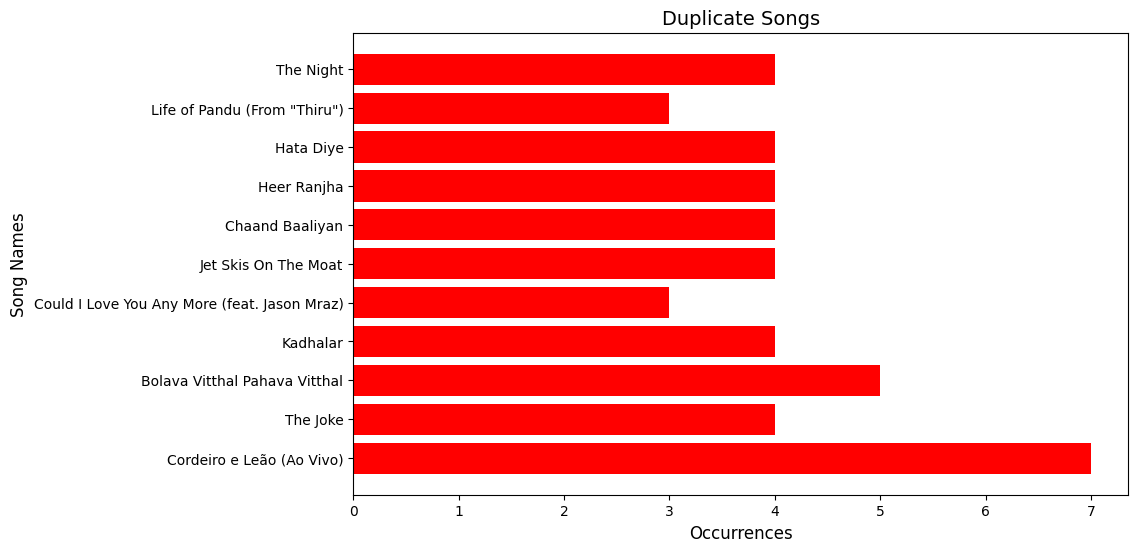

In [31]:
name_counts = Counter(song["name"] for song in recommends)

filtered_names = {name: count for name, count in name_counts.items() if count > 2}

plt.figure(figsize=(10, 6))
plt.barh(list(filtered_names.keys()), list(filtered_names.values()), color="red")

plt.xlabel("Occurrences", fontsize=12)
plt.ylabel("Song Names", fontsize=12)
plt.title("Duplicate Songs", fontsize=14)

plt.show()

Many songs have been recommended more than twice, with one song even appearing in 7 out of 10 playlists.

This is a **significant issue**, as it shows a lack of diversity in recommendations. The problem could be due to the system overfitting to certain songs, possibly because of an imbalance in the dataset or limited features being used. This leads to repeated recommendations, which may result in a less engaging user experience.

### Conclusion

In this notebook, we built a content-based recommendation system that, given a YouTube link, extracts features and suggests similar songs using similarity search on a predefined dataset.

For the similarity search, we used cosine distance, and explored the following approaches:  
   1. Basic similarity search  
   2. Similarity search with filtering based on the preferred genre  

The results were poor, suggesting that a simple cosine similarity approach may not be the best choice for effective recommendations.

To improve performance, we could explore:  
- **Different similarity metrics**: For example using **Euclidean distance** instead of cosine similarity could provide a better measure of song similarity.  
- **Hybrid approach**: Using just a content-based approach was a bit limiting. It could be helpful to add a dataset that supports collaborative filtering.
- **Feature enrichment**: Adding more detailed features like **lyrics**, **tempo**, or **mood** could offer a richer representation of each song, making similarity comparisons more meaningful.  
- **Clustering approach**: K-Means clustering could, for instance, group similar songs together, improving the recommendation process by focusing on clusters instead of individual songs.

In conclusion, while the results were not ideal, this project gave me hands-on experience with a recommendation system, something that seemed like "magic" before but is actually based on solid mathematical principles and algorithms. The skills and knowledge I gained will definitely be useful in future projects, especially when dealing with feature extraction and similarity-based models.